6210407960 นายธนกร วงษ์สนิท

# simpleCNN
# Geometric transformations and Intensity operations

**Import Necessary Libraries**

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from keras.models import Model
from tensorflow.keras.layers import Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import MaxPooling2D
from keras.models import Sequential
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)

2.6.2


In [3]:
cd ./Dataset/Dataset2_GeoTransformAndIntensity

/data/home/b6210407960/Dataset/Dataset2_GeoTransformAndIntensity


In [4]:
ls 

test/  train/  val/


### อ่านข้อมูลtrainและตรวจสอบข้อมูล

In [10]:
disease_types=['Normal', 'COVID']
path = '/data/home/b6210407960/Dataset/Dataset2_GeoTransformAndIntensity/train'
data_dir = os.path.join(path)

In [11]:
data = []
for id, level in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
        
data = pd.DataFrame(data, columns = ['image_file', 'result'])

In [12]:
data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['result'].map({'Normal': 'Negative', 'COVID': 'Positive'})

In [13]:
data.sample(5)

,image_file,result,path,corona_result
7891,COVID/trainCOVID605.png,COVID,/data/home/b6210407960/Dataset/Dataset2_GeoTra...,Positive
4352,Normal/trainNormal4353.png,Normal,/data/home/b6210407960/Dataset/Dataset2_GeoTra...,Negative
5304,Normal/trainNormal5305.png,Normal,/data/home/b6210407960/Dataset/Dataset2_GeoTra...,Negative
990,Normal/trainNormal991.png,Normal,/data/home/b6210407960/Dataset/Dataset2_GeoTra...,Negative
5719,Normal/trainNormal5720.png,Normal,/data/home/b6210407960/Dataset/Dataset2_GeoTra...,Negative


In [14]:
# Data Analysis

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame()
df['corona_result'] = ['Positive', 'Negative']
df['Count'] = [len(data[data['corona_result'] == 'Positive']), len(data[data['corona_result'] == 'Negative'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result", text_auto='', width = 600, 
             color_discrete_sequence = ["green", "red"])

fig.show()

ข้อมูลมีความไม่สมดุล

## train validate test Dataset
Augment train dataset -> โดยเตรียมaugmentภาพโควิดไว้ก่อนหน้าแล้ว ชื่อโฟลเดอร์ว่า `AugmentedCOVID`

In [18]:
disease_types=['Normal', 'COVID']
disease_types_train=['Normal', 'AugmentedCOVID']
path = '/data/home/b6210407960/Dataset/Dataset2_GeoTransformAndIntensity'
data_train = os.path.join(path,'train')
data_val = os.path.join(path,'val')
data_test = os.path.join(path,'test')

In [19]:
os.path.join(data_train, disease_types[0])

'/data/home/b6210407960/Dataset/Dataset2_GeoTransformAndIntensity/train/Normal'

In [20]:
os.path.join(data_val, disease_types[1])

'/data/home/b6210407960/Dataset/Dataset2_GeoTransformAndIntensity/val/COVID'

In [21]:
for defects_id, sp in enumerate(disease_types):
    print(defects_id, sp)

0 Normal
1 COVID


In [22]:
for defects_id, sp in enumerate(disease_types_train):
    print(defects_id, sp)

0 Normal
1 AugmentedCOVID


In [23]:
arr = []
for defects_id, sp in enumerate(disease_types_train):
    for file in os.listdir(os.path.join(data_train, sp)):
        arr.append(['{}/{}'.format(sp, file), defects_id, sp]) #defectID-> Normal=0,COVID=1  
dfTrain = pd.DataFrame(arr, columns=['File', 'DiseaseID','Disease Type'])

In [24]:
arr = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_val, sp)):
        arr.append(['{}/{}'.format(sp, file), defects_id, sp]) #defectID-> Normal=0,COVID=1  
dfVal = pd.DataFrame(arr, columns=['File', 'DiseaseID','Disease Type'])

In [25]:
arr = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_test, sp)):
        arr.append(['{}/{}'.format(sp, file), defects_id, sp]) #defectID-> Normal=0,COVID=1  
dfTest = pd.DataFrame(arr, columns=['File', 'DiseaseID','Disease Type'])

In [29]:
dfTrain.sample(5)

,File,DiseaseID,Disease Type
4987,Normal/trainNormal4988.png,0,Normal
10711,AugmentedCOVID/augmCOVID3425.png,1,AugmentedCOVID
6563,Normal/trainNormal6564.png,0,Normal
1267,Normal/trainNormal1268.png,0,Normal
5047,Normal/trainNormal5048.png,0,Normal


In [30]:
dfVal.sample(5)

,File,DiseaseID,Disease Type
1350,Normal/valNormal1351.png,0,Normal
1289,Normal/valNormal1290.png,0,Normal
896,Normal/valNormal897.png,0,Normal
1157,Normal/valNormal1158.png,0,Normal
780,Normal/valNormal781.png,0,Normal


In [31]:
dfTest.sample(5)

,File,DiseaseID,Disease Type
236,Normal/testNormal237.png,0,Normal
713,Normal/testNormal714.png,0,Normal
521,Normal/testNormal522.png,0,Normal
1057,COVID/testCOVID31.png,1,COVID
797,Normal/testNormal798.png,0,Normal


In [32]:
dfTrain['File'].values

array(['Normal/trainNormal1.png', 'Normal/trainNormal2.png',
       'Normal/trainNormal3.png', ..., 'AugmentedCOVID/augmCOVID7285.png',
       'AugmentedCOVID/augmCOVID7286.png',
       'AugmentedCOVID/augmCOVID7287.png'], dtype=object)

### อ่านข้อมูล

เพื่อที่จะทำการ train model, validate model และ test model ด้วยชุดข้อมูลที่ model ไม่เคยเห็นมาก่อน
* ข้อมูลชุด train model        `X_train`
* ชุดข้อมูลสำหรับ test model    `X_test`
* ชุดข้อมูลสำหรับ validate model`X_val`
* ชุดคำตอบของชุด train model  `Y_train`
* ชุดคำตอบของ validate model `Y_val`
* ชุดคำตอบของ test model     `Y_test`

In [33]:
IMAGE_SIZE = 64
dataset = np.zeros((dfTrain.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)) #arrayไว้เก็บ image ที่อ่าน
# tqdm -> make your loops show a smart progress meter
for i, file in tqdm(enumerate(dfTrain['File'].values)):
    image = cv2.imread(os.path.join(data_train, file)) 
    if image is not None:
        dataset[i] = image
X_train = dataset / 255.
Y_train = dfTrain['DiseaseID'].values
print(X_train.shape)

14574it [01:00, 239.04it/s]


(14574, 64, 64, 3)


In [34]:
print(len(X_train),len(Y_train))

14574 14574


In [35]:
IMAGE_SIZE = 64
dataset = np.zeros((dfVal.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)) #arrayไว้เก็บ image ที่อ่าน
# tqdm -> make your loops show a smart progress meter
for i, file in tqdm(enumerate(dfVal['File'].values)):
    image = cv2.imread(os.path.join(data_val, file)) 
    if image is not None:
        dataset[i] = image
X_val = dataset / 255.
Y_val = dfVal['DiseaseID'].values

2500it [00:06, 371.12it/s]


In [36]:
print(len(X_val),len(Y_val))

2500 2500


In [37]:
IMAGE_SIZE = 64
dataset = np.zeros((dfTest.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3)) #arrayไว้เก็บ image ที่อ่าน
# tqdm -> make your loops show a smart progress meter
for i, file in tqdm(enumerate(dfTest['File'].values)):
    image = cv2.imread(os.path.join(data_test, file)) 
    if image is not None:
        dataset[i] = image
X_test = dataset / 255.
Y_test = dfTest['DiseaseID'].values

1389it [00:04, 339.52it/s]


In [38]:
print(len(X_test),len(Y_test))

1389 1389


In [45]:
print('train -  {}      | val -  {}          |   test -  {}'.format(len(Y_train), len(Y_val), len(Y_test)))
print('train -  {}| val -  {}   |   test -  {}'.format(np.bincount(Y_train), np.bincount(Y_val), np.bincount(Y_test)))
print('train -  {}  | val -  {}   |   test -  {}'.format(np.bincount(Y_train)/len(Y_train), np.bincount(Y_val)/len(Y_val), np.bincount(Y_test)/len(Y_test)))

train -  14574      | val -  2500          |   test -  1389
train -  [7287 7287]| val -  [1875  625]   |   test -  [1027  362]
train -  [0.5 0.5]  | val -  [0.75 0.25]   |   test -  [0.73938085 0.26061915]


In [46]:
#เช็คสัดส่วนแล้ว ->สัดส่วนมีความสมดุลกันแล้ว

## Define CNN Model Architecture

In [47]:
BATCH_SIZE = 64
EPOCHS = 30
SIZE=64
N_ch=3

In [48]:
def build_CNN():
    model = Sequential()
    model.add(Conv2D(32, (3, 3),padding='same', input_shape = (64, 64, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    
    # Compiling the CNN
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()
    
    return model

## Train the Model

In [49]:
model = build_CNN()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('CNN_Model_geomTrans.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(vertical_flip=False,) 

datagen.fit(X_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 128)         0

In [50]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=30,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/30
227/227 [==============================] - 112s 476ms/step - loss: 0.4201 - accuracy: 0.7959 - val_loss: 0.3754 - val_accuracy: 0.8364

Epoch 00001: val_loss improved from inf to 0.37542, saving model to CNN_Model_geomTrans.hdf5
Epoch 2/30
227/227 [==============================] - 86s 378ms/step - loss: 0.2193 - accuracy: 0.9135 - val_loss: 0.3237 - val_accuracy: 0.8640

Epoch 00002: val_loss improved from 0.37542 to 0.32375, saving model to CNN_Model_geomTrans.hdf5
Epoch 3/30
227/227 [==============================] - 88s 387ms/step - loss: 0.1522 - accuracy: 0.9408 - val_loss: 0.3325 - val_accuracy: 0.8772

Epoch 00003: val_loss did not improve from 0.32375
Epoch 4/30
227/227 [==============================] - 83s 368ms/step - loss: 0.1040 - accuracy: 0.9606 - val_loss: 0.3054 - val_accuracy: 0.8864

Epoch 00004: val_loss improved from 0.32375 to 0.30542, saving model to CNN_Model_geomTrans.hdf5
Epoch 5/30
227/227 [==============================] - 84s 370ms/step - loss: 

**Plot the Results**

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

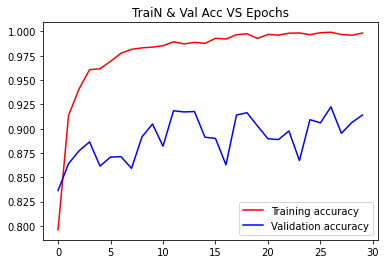

<Figure size 432x288 with 0 Axes>

In [52]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

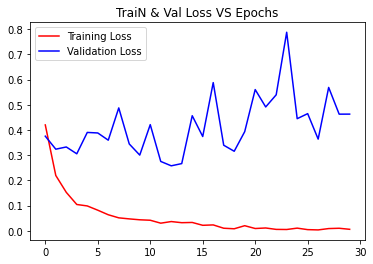

<Figure size 432x288 with 0 Axes>

In [53]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

### Predict

In [54]:
model.load_weights("CNN_Model_geomTrans.hdf5")
score = model.evaluate(X_test, Y_test ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

44/44 [==============================] - 4s 90ms/step - loss: 0.3208 - accuracy: 0.9028
Test Loss: 0.3207966983318329
Test accuracy: 90.28077721595764


In [55]:
predict = model.predict(X_test)
predict[10:20]

array([[2.2592593e-07],
       [1.4506116e-06],
       [5.9730691e-01],
       [2.3121237e-07],
       [5.7443976e-04],
       [4.8376503e-08],
       [9.1920197e-03],
       [7.5338334e-02],
       [1.9109547e-03],
       [1.0498294e-06]], dtype=float32)

In [56]:
y_predict = []
for i in predict:
    if i >= 0.5:
        y_predict.append(1)
    else:
        y_predict.append(0)
y_predict[25:35]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [57]:
x = np.array(y_predict)
print(np.unique(x))

[0 1]


In [58]:
x = np.array(Y_test)
print(np.unique(x))

[0 1]


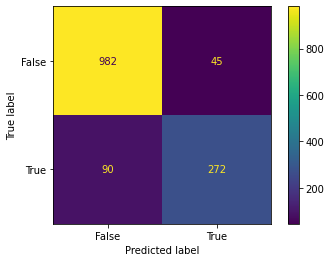

In [59]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

actual = Y_test
predicted = y_predict

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

## Performance measure

In [60]:
Accuracy = metrics.accuracy_score(actual, predicted)
Precision = metrics.precision_score(actual, predicted)
Sensitivity_recall = metrics.recall_score(actual, predicted)
Specificity = metrics.recall_score(actual, predicted, pos_label=0)
F1_score = metrics.f1_score(actual, predicted)

In [61]:
measures = {"Accuracy":Accuracy,
       "Precision":Precision,
       "Sensitivity_recall":Sensitivity_recall,
       "Specificity":Specificity,
       "F1_score":F1_score}

In [62]:
measures

{'Accuracy': 0.9028077753779697,
 'Precision': 0.8580441640378549,
 'Sensitivity_recall': 0.7513812154696132,
 'Specificity': 0.9561830574488802,
 'F1_score': 0.801178203240059}

## Model evaluation

In [63]:
model_eval = pd.DataFrame({
    'Performance_measure': ['Accuracy', 'True Positive Rate / Sensitivity / Recall', 'True Negative Rate / Specificity', 'F1-Score'],
    'Score_test': [Accuracy*100, Sensitivity_recall, Specificity, F1_score]})

In [64]:
model_eval

,Performance_measure,Score_test
0,Accuracy,90.280778
1,True Positive Rate / Sensitivity / Recall,0.751381
2,True Negative Rate / Specificity,0.956183
3,F1-Score,0.801178
